# PredPub: An analysis of potentially predatory journal articles

This project represents a small subset of the work we (me, Daniel Snitkovskiy, and Jevin West) have done for a project we started called "PredPub". The idea behind the project is to help better understand predatory publishing by releasing a dataset on metadata from potentially predatory journals. The data gathering/curation phase of this project took a considerable amount of time this quarter and what is shown here is some preliminary analysis I've done to better understand the underlying structure of how predatory journals are referenced. I do this by analyzing results gathered by passing the title of journal articles into Google's search API and analyzing the returned results.

The dataset I used in the analysis can be found here: https://www.dropbox.com/s/fwm2uobxcbdofs5/google-scrape-may142019.csv?dl=0
The raw data is also available but not publicly. Just shoot me an email: laulck@uw.edu

### Import modules/data

In [1]:
import pandas as pd;
import numpy as np;
import networkx as nx;
from networkx.algorithms import bipartite;
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt;
import matplotlib

matplotlib.rcParams['font.sans-serif'] = 'Calibri'

%matplotlib inline

In [2]:
data = pd.read_csv('../data/google-scrape-may142019.csv')

In [3]:
data.head()

,cacheId,displayLink,fileFormat,formattedUrl,htmlFormattedUrl,htmlSnippet,htmlTitle,kind,link,mime,pagemap,paper_id,paper_title,paper_url,rank,search_id,search_ts,snippet,title
0,NaN,www.researchgate.net,NaN,https://www.researchgate.net/.../330820679_Hyp...,https://www.researchgate.net/.../330820679_<b>...,"Mar 6, 2019 <b>...</b> Request PDF on Research...",<b>Hypervolume-Based Multi-Objective Reinforce...,customsearch#result,https://www.researchgate.net/publication/33082...,NaN,{u'metatags': [{u'twitter:creator': u'@Researc...,-2311570804516226227,Hypervolume-Based Multi-Objective Reinforcemen...,https://astesj.com/v04/i01/p10/,0,-7653030608821440261,2019-05-14 12:44:11.529698,"Mar 6, 2019 ... Request PDF on ResearchGate | ...",Hypervolume-Based Multi-Objective Reinforcemen...
1,kDwLVAvky_0J,www.hil.hiroshima-u.ac.jp,NaN,www.hil.hiroshima-u.ac.jp/~hayashida/studyJour...,www.hil.hiroshima-u.ac.jp/~hayashida/studyJour...,"Hiroyuki Yamamoto, Tomohiro Hayashida, Ichiro ...",広島大学 准教授 林田智弘,customsearch#result,http://www.hil.hiroshima-u.ac.jp/~hayashida/st...,NaN,{u'metatags': [{u'viewport': u'width=device-wi...,-2311570804516226227,Hypervolume-Based Multi-Objective Reinforcemen...,https://astesj.com/v04/i01/p10/,1,-7653030608821440261,2019-05-14 12:44:11.529698,"Hiroyuki Yamamoto, Tomohiro Hayashida, Ichiro ...",広島大学 准教授 林田智弘
2,NaN,www.researchgate.net,NaN,https://www.researchgate.net/.../321810040_Dev...,https://www.researchgate.net/.../321810040_Dev...,Development of <b>interactive multi</b>-<b>obj...,Development of <b>interactive multi</b>-<b>obj...,customsearch#result,https://www.researchgate.net/publication/32181...,NaN,{u'metatags': [{u'twitter:creator': u'@Researc...,-2311570804516226227,Hypervolume-Based Multi-Objective Reinforcemen...,https://astesj.com/v04/i01/p10/,2,-7653030608821440261,2019-05-14 12:44:11.529698,Development of interactive multi-objective rei...,Development of interactive multi-objective rei...
3,5sUUu0O8yJkJ,www.hil.hiroshima-u.ac.jp,NaN,www.hil.hiroshima-u.ac.jp/research_list_journa...,www.hil.hiroshima-u.ac.jp/research_list_journa...,"... and Shinya Sekizaki, &quot;<b>Hypervolume-...",学術論文誌,customsearch#result,http://www.hil.hiroshima-u.ac.jp/research_list...,NaN,{u'metatags': [{u'viewport': u'width=device-wi...,-2311570804516226227,Hypervolume-Based Multi-Objective Reinforcemen...,https://astesj.com/v04/i01/p10/,3,-7653030608821440261,2019-05-14 12:44:11.529698,"... and Shinya Sekizaki, ""Hypervolume-based mu...",学術論文誌
4,NaN,www.researchgate.net,NaN,https://www.researchgate.net/.../225836716_A_H...,https://www.researchgate.net/.../225836716_A_<...,"... limit the area, therefore Hypervolume can ...",A <b>Hypervolume</b>-<b>Based</b> Optimizer fo...,customsearch#result,https://www.researchgate.net/publication/22583...,NaN,{u'metatags': [{u'twitter:creator': u'@Researc...,-2311570804516226227,Hypervolume-Based Multi-Objective Reinforcemen...,https://astesj.com/v04/i01/p10/,4,-7653030608821440261,2019-05-14 12:44:11.529698,"... limit the area, therefore Hypervolume can ...",A Hypervolume-Based Optimizer for High-Dimensi...


### Examine the very first returned results

In [4]:
zeros = data[data['rank'] == 0]

In [5]:
zeros['displayLink'].value_counts()[:20]

www.researchgate.net                 3169
www.ncbi.nlm.nih.gov                 1735
ijpsdr.com                            535
innovareacademics.in                  496
www.semanticscholar.org               352
www.academia.edu                      200
www.rroij.com                         196
pdfs.semanticscholar.org              121
scholar.google.com                    103
citeseerx.ist.psu.edu                  41
ieeexplore.ieee.org                    34
scholar.google.co.in                   25
in.linkedin.com                        23
www.scirp.org                          21
www.escavador.com                      19
arxiv.org                              18
orcid.org                              14
core.ac.uk                             11
eprints.covenantuniversity.edu.ng      11
manipal.pure.elsevier.com              10
Name: displayLink, dtype: int64

In [6]:
zeros[zeros.displayLink == 'arxiv.org'][:5]

,cacheId,displayLink,fileFormat,formattedUrl,htmlFormattedUrl,htmlSnippet,htmlTitle,kind,link,mime,pagemap,paper_id,paper_title,paper_url,rank,search_id,search_ts,snippet,title
2208,fHukjWgpFiIJ,arxiv.org,NaN,https://arxiv.org/abs/1707.01609,https://arxiv.org/abs/1707.01609,"Jul 6, 2017 <b>...</b> Title:<b>Three-Pass Pro...",<b>Three-Pass Protocol Implementation in Vigen...,customsearch#result,https://arxiv.org/abs/1707.01609,NaN,{u'metatags': [{u'og:url': u'https://arxiv.org...,2053403729177195405,Three-Pass Protocol Implementation in Vigenere...,https://astesj.com/v02/i05/p01/,0,8924146105173603121,2019-05-14 12:53:54.890867,"Jul 6, 2017 ... Title:Three-Pass Protocol Impl...",Three-Pass Protocol Implementation in Vigenere...
2267,h6MTNAo-oMYJ,arxiv.org,NaN,https://arxiv.org/abs/1707.03319,https://arxiv.org/abs/1707.03319,"Jul 11, 2017 <b>...</b> ... <b>Nature</b> in <...",<b>Modification of Symmetric Cryptography with...,customsearch#result,https://arxiv.org/abs/1707.03319,NaN,{u'metatags': [{u'og:url': u'https://arxiv.org...,-5736854831358231173,Modification of Symmetric Cryptography with Co...,https://astesj.com/v02/i05/p02/,0,3091911605861344787,2019-05-14 12:54:13.345388,"Jul 11, 2017 ... ... Nature in Matrix of Chipe...",Modification of Symmetric Cryptography with Co...
3172,j6f_IkbP1aMJ,arxiv.org,NaN,https://arxiv.org/abs/1804.09988,https://arxiv.org/abs/1804.09988,"Apr 26, 2018 <b>...</b> Computer Science &gt; ...",<b>A security approach based on honeypots: Pro...,customsearch#result,https://arxiv.org/abs/1804.09988,NaN,{u'metatags': [{u'og:url': u'https://arxiv.org...,1745172337122941535,A security approach based on honeypots: Protec...,https://astesj.com/v02/i03/p26/,0,-3221285077605122758,2019-05-14 12:57:40.392224,"Apr 26, 2018 ... Computer Science > Cryptograp...",A security approach based on honeypots: Protec...
4489,HSPnMM-aYCsJ,arxiv.org,NaN,https://arxiv.org/abs/1804.08717,https://arxiv.org/abs/1804.08717,"Apr 17, 2018 <b>...</b> ... of <b>extra four n...",<b>On discovery of extra four new dispersive S...,customsearch#result,https://arxiv.org/abs/1804.08717,NaN,{u'metatags': [{u'og:url': u'https://arxiv.org...,-340529821188504833,ON DISCOVERY OF EXTRA FOUR NEW DISPERSIVE SH-W...,http://www.cjpas.net/?page_id=276&id=1767,0,-8663245977871200645,2019-05-14 13:03:44.169123,"Apr 17, 2018 ... ... of extra four new dispers...",On discovery of extra four new dispersive SH-w...
4549,7xG_f_WkOdkJ,arxiv.org,NaN,https://arxiv.org/abs/1711.10643,https://arxiv.org/abs/1711.10643,"Nov 29, 2017 <b>...</b> Coherent detection req...",<b>A Review on Cooperative Diversity Technique...,customsearch#result,https://arxiv.org/abs/1711.10643,NaN,{u'metatags': [{u'og:url': u'https://arxiv.org...,9212624524624654502,A REVIEW ON COOPERATIVE DIVERSITY TECHNIQUES B...,http://www.cjpas.net/?page_id=276&id=1754,0,448406453458824030,2019-05-14 13:04:06.645441,"Nov 29, 2017 ... Coherent detection requires e...",A Review on Cooperative Diversity Techniques B...


In [7]:
len(data)

52915

In [8]:
data['paper_title'].nunique()

7689

### Grouping/aggregating results based on source type

In [9]:
toFilter = ['www.researchgate.net', 'www.semanticscholar.org', 'scholar.google.com', 'www.academia.edu', 'scholar.google.com',
           'scholar.google.co.in', 'in.linkedin.com', 'pdfs.semanticscholar.org', 'orcid.org']

In [10]:
data['displayLink'].value_counts()[:20]

www.researchgate.net            14901
www.semanticscholar.org          8933
www.ncbi.nlm.nih.gov             3681
innovareacademics.in             1574
ijpsdr.com                       1249
scholar.google.com                985
www.academia.edu                  907
www.hindawi.com                   855
www.rroij.com                     659
oaji.net                          609
eurekamag.com                     549
scholar.google.co.in              539
pdfs.semanticscholar.org          465
orcid.org                         387
www.science.gov                   347
journaldatabase.info              326
www.niscair.res.in                303
www.mdpi.com                      292
europepmc.org                     277
www.thegoodscentscompany.com      274
Name: displayLink, dtype: int64

In [11]:
len(data)

52915

In [12]:
data.columns

Index([u'cacheId', u'displayLink', u'fileFormat', u'formattedUrl',
       u'htmlFormattedUrl', u'htmlSnippet', u'htmlTitle', u'kind', u'link',
       u'mime', u'pagemap', u'paper_id', u'paper_title', u'paper_url', u'rank',
       u'search_id', u'search_ts', u'snippet', u'title'],
      dtype='object')

In [13]:
subset = data[['paper_id', 'paper_title', 'paper_url', 'rank', 'displayLink']]

In [14]:
subset.head()

,paper_id,paper_title,paper_url,rank,displayLink
0,-2311570804516226227,Hypervolume-Based Multi-Objective Reinforcemen...,https://astesj.com/v04/i01/p10/,0,www.researchgate.net
1,-2311570804516226227,Hypervolume-Based Multi-Objective Reinforcemen...,https://astesj.com/v04/i01/p10/,1,www.hil.hiroshima-u.ac.jp
2,-2311570804516226227,Hypervolume-Based Multi-Objective Reinforcemen...,https://astesj.com/v04/i01/p10/,2,www.researchgate.net
3,-2311570804516226227,Hypervolume-Based Multi-Objective Reinforcemen...,https://astesj.com/v04/i01/p10/,3,www.hil.hiroshima-u.ac.jp
4,-2311570804516226227,Hypervolume-Based Multi-Objective Reinforcemen...,https://astesj.com/v04/i01/p10/,4,www.researchgate.net


In [15]:
subset['category'] = ''

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [16]:
subset.head()

,paper_id,paper_title,paper_url,rank,displayLink,category
0,-2311570804516226227,Hypervolume-Based Multi-Objective Reinforcemen...,https://astesj.com/v04/i01/p10/,0,www.researchgate.net,
1,-2311570804516226227,Hypervolume-Based Multi-Objective Reinforcemen...,https://astesj.com/v04/i01/p10/,1,www.hil.hiroshima-u.ac.jp,
2,-2311570804516226227,Hypervolume-Based Multi-Objective Reinforcemen...,https://astesj.com/v04/i01/p10/,2,www.researchgate.net,
3,-2311570804516226227,Hypervolume-Based Multi-Objective Reinforcemen...,https://astesj.com/v04/i01/p10/,3,www.hil.hiroshima-u.ac.jp,
4,-2311570804516226227,Hypervolume-Based Multi-Objective Reinforcemen...,https://astesj.com/v04/i01/p10/,4,www.researchgate.net,


In [17]:
subset.loc[subset.displayLink == 'www.researchgate.net', 'category'] = 'self-promotion'
subset.loc[subset.displayLink == 'www.semanticscholar.org', 'category'] = 'search engine'
subset.loc[subset.displayLink == 'www.ncbi.nlm.nih.gov', 'category'] = 'government'
subset.loc[subset.displayLink == 'innovareacademics.in', 'category'] = 'publisher'
subset.loc[subset.displayLink == 'ijpsdr.com', 'category'] = 'publisher'
subset.loc[subset.displayLink == 'scholar.google.com', 'category'] = 'search engine'
subset.loc[subset.displayLink == 'www.academia.edu', 'category'] = 'academia'
subset.loc[subset.displayLink == 'www.hindawi.com', 'category'] = 'publisher'
subset.loc[subset.displayLink == 'www.rroij.com', 'category'] = 'publisher'
subset.loc[subset.displayLink == 'oaji.net', 'category'] = 'publisher'
subset.loc[subset.displayLink == 'eurekamag.com', 'category'] = 'search engine'
subset.loc[subset.displayLink == 'scholar.google.co.in', 'category'] = 'search engine'
subset.loc[subset.displayLink == 'pdfs.semanticscholar.org', 'category'] = 'search engine'
subset.loc[subset.displayLink == 'www.science.gov', 'category'] = 'government'
subset.loc[subset.displayLink == 'www.researchgate.net', 'category'] = 'self-promotion'
subset.loc[subset.displayLink == 'orcid.org', 'category'] = 'self-promotion'
subset.loc[subset.displayLink == 'www.linkedin.com', 'category'] = 'self-promotion'
subset.loc[subset.displayLink == 'independent.academia.edu', 'category'] = 'academia'
subset.loc[subset.displayLink == 'europepmc.org', 'category'] = 'search engine'
subset.loc[subset.displayLink == 'citeseerx.ist.psu.edu', 'category'] = 'academia'
subset.loc[subset.displayLink == 'in.linkedin.com', 'category'] = 'self-promotion'
subset.loc[subset.displayLink == 'journaldatabase.info', 'category'] = 'search engine'
subset.loc[subset.displayLink == 'www.mdpi.com', 'category'] = 'publisher'
subset.loc[subset.displayLink == 'link.springer.com', 'category'] = 'publisher'
subset.loc[subset.displayLink == 'ijpsr.com', 'category'] = 'publisher'
subset.loc[subset.displayLink == 'www.niscair.res.in', 'category'] = 'publisher'
subset.loc[subset.displayLink == 'research.omicsgroup.org', 'category'] = 'publisher'
subset.loc[subset.displayLink == 'www.omicsonline.org', 'category'] = 'publisher'

C:\Anaconda2\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [18]:
check = subset[subset.category == '']
print len(subset)
print len(check) * 1.0 / len(subset)
check.displayLink.value_counts()[:20]

52915
0.261967306057


www.thegoodscentscompany.com    274
www.escavador.com               260
www.scirp.org                   256
www.pubfacts.com                248
www.oalib.com                   203
scialert.net                    189
www.stuartxchange.org           150
www.tandfonline.com             142
go.galegroup.com                140
www.scribd.com                  114
journals.sagepub.com            107
search.ebscohost.com            102
kns.cnki.net                     95
www.slideshare.net               95
www.sciencedirect.com            93
www.frontiersin.org              90
scholar.google.co.id             84
docplayer.net                    83
www.scielo.br                    79
www.facebook.com                 76
Name: displayLink, dtype: int64

In [19]:
network = subset[subset.category != ''][['paper_title', 'displayLink']]
print len(network)
counts = network['paper_title'].value_counts()
counts = counts[counts > 5]
network = network[network.paper_title.isin(counts.index)]
print len(network)
counts = network['displayLink'].value_counts()
counts = counts[counts > 5]
network = network[network.displayLink.isin(counts.index)]
print len(network)

39053
24213
24213


### Building bipartite network of papers and search results

WARNING: This takes some time to run

In [20]:
g = nx.Graph()
g.add_nodes_from(network['paper_title'].unique(), bipartite = 0)
g.add_nodes_from(network['displayLink'].unique(), bipartite = 1)
for index, row in network.iterrows():
    g.add_edges_from([(row['paper_title'], row['displayLink'])])

In [21]:
groupings = bipartite.color(g)
values = [groupings.get(node, 0.5) for node in g.nodes()]
pos = nx.kamada_kawai_layout(g)

[]

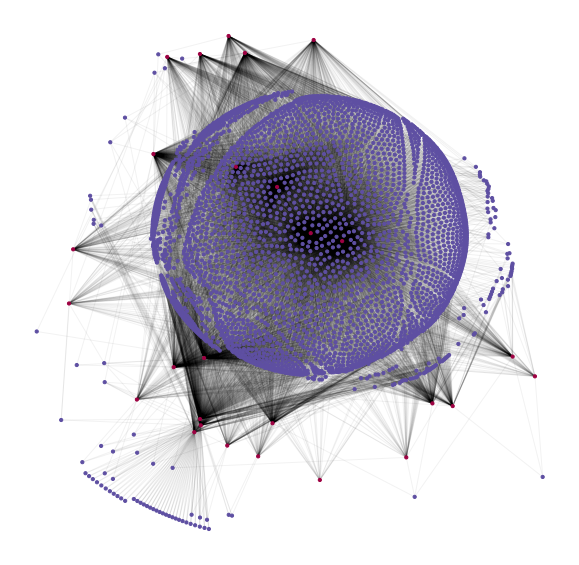

In [22]:
fig, ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(10, 10)
nx.draw_networkx_nodes(g, pos = pos, node_size = 10, with_labels=False, cmap = plt.get_cmap('Spectral'), node_color = values)
nx.draw_networkx_edges(g, pos = pos, width = 1, alpha = 0.05)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
#plt.savefig('network.png', dpi = 1200)

### Analyzing proportions of returned search results by category

In [23]:
props = subset[subset.category != '']
props = props.category.value_counts() / len(props)
props = props.sort_values(ascending = False)

In [24]:
props

self-promotion    0.400609
search engine     0.309170
publisher         0.157248
government        0.103142
academia          0.029831
Name: category, dtype: float64

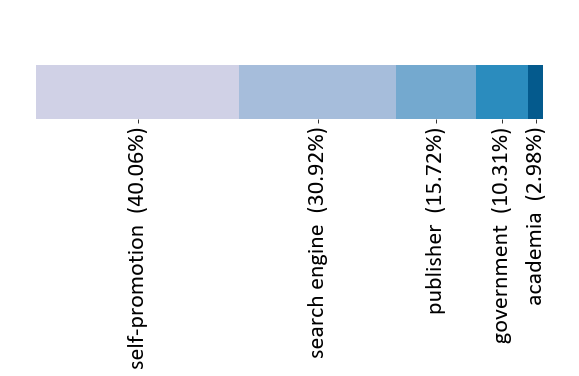

In [25]:
total = 0
colors = ['#d0d1e6', '#a6bddb', '#74a9cf', '#2b8cbe', '#045a8d']

order = 5
ticks = []
labels = []
fig, ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(10, 2)
for each, label, col in zip(props, props.index, colors):
    mul = 10
    ticks.append((total + 0.5 * each) * mul)
    labels.append(label + "  (" + str(np.round(each * 10000) / 100) + '%)')
    total = total + each
    plt.bar(0, [0.5, 0.5], color = [col], zorder = order, width = total * mul, align = 'edge')
    order = order - 1

#plt.xlim([-1.5, 1])
plt.ylim([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks(ticks, labels, rotation = 90);
plt.yticks([]);
ax.tick_params(axis='both', which='major', labelsize=24)
#plt.savefig('barProps.png', bbox_inches = 'tight', dpi = 1200)

In [26]:
props

self-promotion    0.400609
search engine     0.309170
publisher         0.157248
government        0.103142
academia          0.029831
Name: category, dtype: float64

In [27]:
subset.head()

,paper_id,paper_title,paper_url,rank,displayLink,category
0,-2311570804516226227,Hypervolume-Based Multi-Objective Reinforcemen...,https://astesj.com/v04/i01/p10/,0,www.researchgate.net,self-promotion
1,-2311570804516226227,Hypervolume-Based Multi-Objective Reinforcemen...,https://astesj.com/v04/i01/p10/,1,www.hil.hiroshima-u.ac.jp,
2,-2311570804516226227,Hypervolume-Based Multi-Objective Reinforcemen...,https://astesj.com/v04/i01/p10/,2,www.researchgate.net,self-promotion
3,-2311570804516226227,Hypervolume-Based Multi-Objective Reinforcemen...,https://astesj.com/v04/i01/p10/,3,www.hil.hiroshima-u.ac.jp,
4,-2311570804516226227,Hypervolume-Based Multi-Objective Reinforcemen...,https://astesj.com/v04/i01/p10/,4,www.researchgate.net,self-promotion


### Performing some clustering

Note: I tried using some of the approaches from class but had little success. Instead, here I create a paper co-occurence matrix based on the search results and then compute the Ward distance. Then, I cluster the matrix based on the Ward distance.

In [28]:
subset['ones'] = 1
check = subset.pivot_table('ones', ['paper_id', 'displayLink'])

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [29]:
coMatrix = check.unstack()
coMatrix = coMatrix.fillna(0)

In [30]:
print coMatrix.shape
coMatrix.head()

(7858, 4169)


ones                                          \
displayLink          123.academia.edu 123doc.org 14.139.186.108 156.17.100.82   
paper_id                                                                        
-9222374214100718826              0.0        0.0            0.0           0.0   
-9221103650654290101              0.0        0.0            0.0           0.0   
-9220576880774963704              0.0        0.0            0.0           0.0   
-9220447432292247451              0.0        0.0            0.0           0.0   
-9219123063660350681              0.0        0.0            0.0           0.0   

                                                                   \
displayLink          157.86.246.240 182.75.124.174 192.169.213.57   
paper_id                                                            
-9222374214100718826            0.0            0.0            0.0   
-9221103650654290101            0.0            0.0            0.0   
-9220576880774963704            0.0            0.0            0.0   
-9220447432292247451            0.0            0.0            0.0   
-9219123063660350681            0.0            0.0            0.0   

                                         \
displayLink          1croreprojects.com   
paper_id                                  
-9222374214100718826                0.0   
-9221103650654290101                0.0   
-9220576880774963704                0.0   
-9220447432292247451                0.0   
-9219123063660350681                0.0   

                                                                              \
displayLink          2018.asianhospitalmanagementawards.com 2018.icrapam.org   
paper_id                                                                       
-9222374214100718826                                    0.0              0.0   
-9221103650654290101                                    0.0              0.0   
-9220576880774963704                                    0.0              0.0   
-9220447432292247451                                    0.0              0.0   
-9219123063660350681                                    0.0              0.0   

                             ...                                    \
displayLink                  ...         zdrowie.tvn.pl zenodo.org   
paper_id                     ...                                     
-9222374214100718826         ...                    0.0        0.0   
-9221103650654290101         ...                    0.0        0.0   
-9220576880774963704         ...                    0.0        0.0   
-9220447432292247451         ...                    0.0        0.0   
-9219123063660350681         ...                    0.0        0.0   

                                                                         \
displayLink          zgys.cnjournals.org zhongyao.bucm.edu.cn zjrms.com   
paper_id                                                                  
-9222374214100718826                 0.0                  0.0       0.0   
-9221103650654290101                 0.0                  0.0       0.0   
-9220576880774963704                 0.0                  0.0       0.0   
-9220447432292247451                 0.0                  0.0       0.0   
-9219123063660350681                 0.0                  0.0       0.0   

                                                         \
displayLink          zmyo.beun.edu.tr zoology.uoc.ac.in   
paper_id                                                  
-9222374214100718826              0.0               0.0   
-9221103650654290101              0.0               0.0   
-9220576880774963704              0.0               0.0   
-9220447432292247451              0.0               0.0   
-9219123063660350681              0.0               0.0   

                                                                            
displayLink          zoology14bu.wixsite.com zu.edu.jo zyyxy.paperopen.com  
paper_id                                                

In [31]:
coMatrix = coMatrix.values.dot(coMatrix.values.T)
np.fill_diagonal(coMatrix, 0)

In [32]:
coMatrix.shape

(7858L, 7858L)

In [33]:
row_sums = coMatrix.sum(axis = 1)
coMatrixNorm = coMatrix / row_sums[:, np.newaxis]

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app


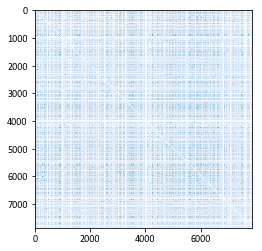

In [34]:
plt.imshow(coMatrix, cmap='Blues')
plt.show()

In [35]:
link = coMatrix
np.fill_diagonal(link, 0)
link = normalize(link, axis = 1, norm = 'l1')
link = linkage(link, 'ward')

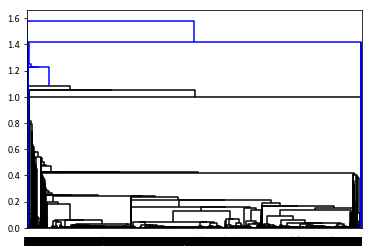

In [36]:
fig, ax = plt.subplots()
dn = dendrogram(link)
dendCols = [int(each.get_text()) for each in ax.get_xticklabels()]

In [37]:
coMatrixRe = coMatrix[dendCols, :]
coMatrixRe = coMatrixRe[:, dendCols]

In [38]:
coMatrixRe.shape

(7858L, 7858L)

([], <a list of 0 Text yticklabel objects>)

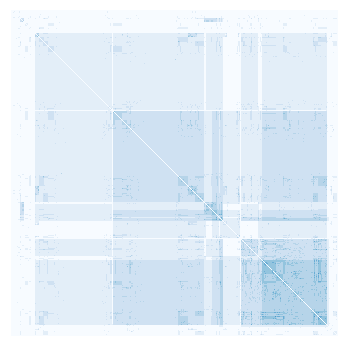

In [39]:
fig, ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.imshow(coMatrixRe, cmap='Blues')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks([]);
plt.yticks([]);
#plt.savefig('coMatrix.png', dpi = 1200)